# Song et al. (2020) itol mantel figure reproduce attempt 

## After hours and hours of blood sweat and tears I have finally got python, jupyter, and qiime2 to work in peaceful coexistence

### Some notes to remember:

1. Download qiime2 in ubuntu FIRST then when u activate your environment, download ipython and jupyter stuff and kernel in the virtual env. Then there should be code to add kernel to environment. 
2. Then you launch jupyter from the venv and qiime2 can finally be imported in jupyter. This took me forever to figure out. Also had trouble with other packages, but after doing the !sys pip install method in jupyter I had almost no issues. 
3. TreeTime is what I shouldve been using all along, just google TreeTime database to make the tree and then you can use their code to line up all tree, distance matrices, and metadata. Code is so much quicker and easier than in R/excel

In [91]:
import sys
!{sys.executable} -m pip install ecopy

In [145]:
import skbio as skb
import numpy as np
import pandas as pd
import seaborn as sns
from ecopy import Mantel

In [146]:
from matplotlib import pyplot as plt
import pylab as pl
from qiime2 import Artifact
from skbio import TreeNode
from skbio.stats.distance import mantel
from scipy.stats import linregress
from scipy.spatial.distance import squareform, pdist
from os.path import abspath, join
from os import makedirs
import matplotlib as mpl

In [147]:
%matplotlib inline

In [148]:
pwd

'/mnt/c/Users/samde'

In [149]:
tree_dir = abspath('../samde/python/trees')
host_tree_fp = join(tree_dir, 'fishtree.nwk')
host_tree_fp

'/mnt/c/Users/samde/python/trees/fishtree.nwk'

In [150]:
host_tree= skb.io.read(host_tree_fp, format='newick', 
                       into=TreeNode,
                       convert_underscores=False)

host_tips = [x.name for x in host_tree.tips()]
len(host_tips)

20

In [151]:
md_dir = '../samde/python/metadata'
host_md_fp = join(md_dir, 'allmerged-metadata4.txt')
host_md = pd.read_csv(host_md_fp, sep='\t')

host_md = host_md.loc[(host_md['treetax'].isin(host_tips))]

In [152]:
len(host_md['sampleid'])


550

In [153]:
# filter to just tetrapods
include_classes = ['Actinopterygii']

host_md = host_md.loc[host_md['host'].isin(include_classes)]

In [154]:

dm_dir = abspath('../samde/python/bdiv')
dm_fp = join(dm_dir, 'unweighted_unifrac_distance_matrixActinopterygii1k.qza')
dm_art = Artifact.load(dm_fp)
dm = dm_art.view(skb.DistanceMatrix)

In [155]:
md_ids = set(host_md['sampleid'])

dm_ids = set(dm.ids)

shared_ids = dm_ids & md_ids

In [156]:
len(md_ids)

550

In [157]:
len(dm_ids)

413

In [158]:
len(shared_ids)

403

In [159]:
host_md = host_md.loc[host_md['sampleid'].isin(shared_ids)]
dm = dm.filter(list(shared_ids))

In [160]:
host_md.shape

(403, 15)

In [161]:
dm.shape

(403, 403)

In [162]:
host_tree = host_tree.shear(host_md['treetax'])
host_tips = [x.name for x in host_tree.tips()]

In [163]:
host_tips

['Dascyllus_flavicaudus',
 'Abudefduf_sexfasciatus',
 'Stegastes_nigricans',
 'Aulostomus_chinensis',
 'Epinephelus_merra',
 'Cephalopholis_urodeta',
 'Cephalopholis_argus',
 'Chaetodon_auriga',
 'Chaetodon_reticulatus',
 'Chaetodon_ornatissimus',
 'Ctenochaetus_striatus',
 'Zebrasoma_scopas',
 'Naso_lituratus',
 'Rhinecanthus_aculeatus',
 'Halichoeres_trimaculatus',
 'Chlorurus_spilurus',
 'Epibulus_insidiator',
 'Sargocentron_spiniferum',
 'Myripristis_berndti',
 'Myripristis_violacea']

In [164]:
len(host_tips)

20

In [165]:
subset = False

In [166]:
# subset the tree if desired
if subset:
    host_subset = np.random.choice(host_tips, size=100, replace=False)
else:
    host_subset = host_tips

host_tree_subset = host_tree.shear(host_subset)

host_ids_subset = host_md.loc[host_md['treetax'].isin(host_subset), 'sampleid']

In [167]:
len(host_ids_subset)

403

In [168]:
one_per_sp = True

In [169]:
if one_per_sp:
    host_md = host_md.loc[(host_md['sampleid'].isin(host_ids_subset)) &
                          (host_md['sampleid'].isin(dm.ids)),].groupby('treetax').first()

    host_md =  host_md.loc[(host_md['sampleid'].isin(host_ids_subset)) &
                          (host_md['sampleid'].isin(dm.ids)),].groupby('treetax').first().reset_index()
    host_ids_subset = list(set(host_ids_subset) & set(host_md['sampleid']))

In [170]:
len(host_ids_subset)

20

In [171]:
patristic_dm = host_tree_subset.tip_tip_distances()

In [172]:
patristic_dm.shape

(20, 20)

So now to make diet matrix I went back into relatedness script in R (or start fresh one) and you just use dcast function from reshape2 to make diet matrix from metadata, which in my case is basically binary (0,1), to make distance matrix

In [173]:
md_dir = '../samde/python/metadata'
host_diet_file = join(md_dir, 'alldietd.csv')
host_diet_df = pd.read_csv(host_diet_file, sep=',',index_col=0)
#host_diet_df = host_diet_df.dropna()
host_diet_df.head()

,carnivore,corallivore,detritivore,herbivore,omnivore,planktivore
sampleid,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,1.0,0.0,0.0
10,0.0,1.0,0.0,0.0,0.0,0.0
100,1.0,0.0,0.0,0.0,0.0,0.0
101,1.0,0.0,0.0,0.0,0.0,0.0


In [174]:
#host_diet_df.set_index('sampleid', inplace=True)  dont need it

In [175]:
host_diet_df = host_diet_df.loc[host_ids_subset,:].dropna()
host_diet_df
#for some reason this works...guess i dont need sampleid as a column name like in github

,carnivore,corallivore,detritivore,herbivore,omnivore,planktivore
23,0.0,0.0,0.0,0.0,1.0,0.0
14,0.0,1.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,1.0
29,0.0,0.0,0.0,0.0,1.0,0.0
36,1.0,0.0,0.0,0.0,0.0,0.0
63,1.0,0.0,0.0,0.0,0.0,0.0
22,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0
37,1.0,0.0,0.0,0.0,0.0,0.0
A73,1.0,0.0,0.0,0.0,0.0,0.0


In [176]:
diet_dm = skb.DistanceMatrix(squareform(pdist(host_diet_df.iloc[:, :], metric='jaccard')))
diet_dm.ids = host_diet_df.index

In [177]:
diet_dm.shape

(20, 20)

In [178]:
rename_df = host_md.loc[host_md['sampleid'].isin(diet_dm.ids),
                             ['sampleid','treetax']].set_index('sampleid')
rename = [rename_df.loc[x, 'treetax'] for x in diet_dm.ids]

In [179]:
diet_dm.ids = rename

## Subset DM to remaining hosts and rename by tree

In [180]:
dm_subset = dm.filter(list(host_ids_subset))

In [181]:
dm_subset.shape

(20, 20)

In [182]:
rename_df = host_md.loc[host_md['sampleid'].isin(dm_subset.ids),
                             ['sampleid','treetax']].set_index('sampleid')
rename = [rename_df.loc[x, 'treetax'] for x in dm_subset.ids]

In [183]:
dm_subset.ids = rename

In [184]:
set(dm_subset.ids) == set(patristic_dm.ids)

True

In [185]:
def recursive_mantel(tree, dm1, dm2, min_size=7, **kwargs):
    i = 0
    nodes = tree.count(tips=True) * 2 - 1
    tree.assign_ids()
    node_dict = {}
    for n in tree.postorder():
        label = n.name
        i += 1
        # see if you're below minimum clade size
        if n.count(tips=True) < min_size:
            continue
        # if not, run mantel
        else:
            tips = [t.name for t in n.tips()]
            dm1_s = dm1.filter(tips)
            dm2_s = dm2.filter(tips)
            corr, p, _ = mantel(dm1_s, dm2_s, **kwargs)
            node_dict[n.name] = (corr, p)
    
        pct = (i / nodes)
        
        if np.round(pct * 100) % 10 == 0:
            print(pct)
    return(node_dict)

In [186]:
def recursive_mantel_ecopy(tree, dm1, dm2, min_size=7, **kwargs):
    i = 0
    nodes = tree.count(tips=True) * 2 - 1
    tree.assign_ids()
    node_dict = {}
    for n in tree.postorder():
        label = n.name
        i += 1
        # see if you're below minimum clade size
        if n.count(tips=True) < min_size:
            continue
        # if not, run mantel
        else:
            tips = [t.name for t in n.tips()]
            dm1_s = dm1.filter(tips)
            dm2_s = dm2.filter(tips)
            res = Mantel(dm1_s.data, dm2_s.data, **kwargs)
            
            node_dict[n.name] = (res.r_obs, res.pval)
    
        pct = (i / nodes)
        
        if np.round(pct * 100) % 10 == 0:
            print(pct)
    return(node_dict)

In [187]:
def recursive_partial_mantel_ecopy(tree, dm1, dm2, dmc, min_size=7, **kwargs):
    i = 0
    nodes = tree.count(tips=True) * 2 - 1
    tree.assign_ids()
    node_dict = {}
    for n in tree.postorder():
        label = n.name
        i += 1
        # see if you're below minimum clade size
        if n.count(tips=True) < min_size:
            continue
        # if not, run mantel
        else:
            tips = [t.name for t in n.tips()]
            dm1_s = dm1.filter(tips)
            dm2_s = dm2.filter(tips)
            dmc_s = dmc.filter(tips)
            res = Mantel(dm1_s.data, dm2_s.data, d_condition=dmc_s.data, **kwargs)
            
            node_dict[n.name] = (res.r_obs, res.pval)
    
        pct = (i / nodes)
        
        if np.round(pct * 100) % 10 == 0:
            print(pct)
    return(node_dict)

In [188]:
# assign internal node names, non-integer

host_tree_subset.assign_ids()

for n in host_tree_subset.postorder():
    if n.is_tip():
        continue
    elif n.name[0].isdigit(): 
        n.name = "node%s" % n.name

TypeError: 'NoneType' object is not subscriptable

In [106]:
tips = set(patristic_dm.ids) & set(dm_subset.ids) & set(diet_dm.ids)

In [107]:
len(tips)

20

In [108]:
run = True

In [109]:
if run:
    node_dict_spearman = recursive_mantel(host_tree_subset, patristic_dm, dm_subset, method='spearman')

1.0


In [110]:
if run:
    node_dict_pearson = recursive_mantel(host_tree_subset, patristic_dm, dm_subset, method='pearson')

1.0


## Run Partial Mantels tests conditioned on diet

In [111]:
if run:
    node_dict_spearman_partial = recursive_partial_mantel_ecopy(host_tree_subset.shear(tips),
                                      patristic_dm.filter(tips),
                                      dm_subset.filter(tips),
                                      diet_dm.filter(tips),
                                      test='spearman')

/home/samd1993/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/ecopy/matrix_comp/mantel.py:193: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(Z, y_flat)[0]


1.0


In [112]:
if run:
    node_dict_pearson_partial = recursive_partial_mantel_ecopy(host_tree_subset.shear(tips),
                                      patristic_dm.filter(tips),
                                      dm_subset.filter(tips),
                                      diet_dm.filter(tips),
                                      test='pearson')

1.0


In [113]:
pwd

'/mnt/c/Users/samde'

In [114]:
out_dir = '../samde/python/mantelfish'
makedirs(out_dir, exist_ok=True)
out_dir

'../samde/python/mantel'

In [115]:
if run:
    host_tree_subset.write(join(out_dir,'annotated_host_tree.tre'), format='newick')

In [116]:
if run:
    node_df_pearson = pd.DataFrame.from_dict(node_dict_pearson, orient='index')
    node_df_pearson.columns = ['r','p']
    node_df_pearson.to_csv(join(out_dir, 'mantel.uwdist.pearson.csv'))

In [117]:
if run:
    node_df_spearman =  pd.DataFrame.from_dict(node_dict_spearman, orient='index')
    node_df_spearman.columns = ['r','p']
    node_df_spearman.to_csv(join(out_dir, 'mantel.uwdist.spearman.csv'))

In [118]:
if run:
    node_df_pearson_partial = pd.DataFrame.from_dict(node_dict_pearson_partial, orient='index')
    node_df_pearson_partial.columns = ['r','p']
    node_df_pearson_partial.to_csv(join(out_dir, 'mantel_partial.juwdist.pearson.csv'))

In [119]:
if run:
    node_df_spearman_partial =  pd.DataFrame.from_dict(node_dict_spearman_partial, orient='index')
    node_df_spearman_partial.columns = ['r','p']
    node_df_spearman_partial.to_csv(join(out_dir, 'mantel_partial.uwdist.spearman.csv'))

In [120]:
host_tree_subset = TreeNode.read(join(out_dir,'annotated_host_tree.tre'))

In [121]:
node_df_pearson = pd.read_csv(join(out_dir, 'mantel.uwdist.pearson.csv'), index_col=0)
node_df_spearman = pd.read_csv(join(out_dir, 'mantel.uwdist.spearman.csv'), index_col=0)
node_df_pearson_partial = pd.read_csv(join(out_dir, 'mantel_partial.uwdist.pearson.csv'), index_col=0)
node_df_spearman_partial = pd.read_csv(join(out_dir, 'mantel_partial.uwdist.spearman.csv'), index_col=0)

In [122]:
def node_values(tips, tree, node_df, tree_dm, dist_dm):
    node_name = tree.lca(tips).name
    
    r = node_df_pearson.loc[node_name, 'r']
    p = node_df_pearson.loc[node_name, 'p']
    
    pats = patristic_dm.filter(tips)
    dsts = dm_subset.filter(tips)

    x = pats.to_series()
    y = dsts.to_series()

    slope, _, _, _, _ = linregress(x, y)
    
    plot = sns.lmplot('x',
                      'y',
                      pd.DataFrame({'x': x, 'y': y}).reset_index(),
                      scatter_kws={'alpha':0.1})
    plt.ylim(0.5, 1.05)

    print(("r: {r}\n"
       "p: {p}\n"
       "m: {m:8.7f}\n").format(r=r, p=p, m=slope))
    
#     plot

In [123]:
tips = set(host_md.loc[host_md['host'] == 'Actinopterygii','treetax']) & set(host_subset)

node_values(tips, host_tree_subset, node_df_pearson, patristic_dm, dm_subset)

KeyError: None

In [131]:
itol_dir = '../samde/python/itolfish'

In [132]:

import matplotlib as mpl

In [133]:
node_df_pearson['r'].max()

0.259576881288455

In [134]:
node_df_spearman['r'].max()

-0.0477444654222307

In [135]:

node_df_pearson_partial['r'].max()

0.7986208431028278

In [136]:
node_df_spearman_partial['r'].max()

-0.0436965012881243

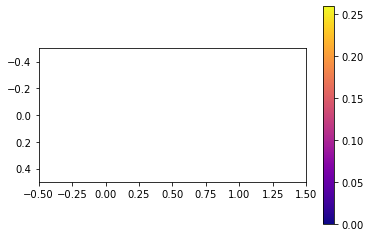

In [137]:
# create dummy invisible image
# (use the colormap you want to have on the colorbar)
cmax = node_df_pearson['r'].max()
img = plt.imshow(np.array([[0,cmax]]), cmap=mpl.cm.plasma)
img.set_visible(False)

plt.colorbar(orientation="vertical")

# add any other things you want to the figure.
#plt.plot(np.random.rand(30))

In [138]:
def colorbar(fp,
             cmax=1,
             size=(4,.7)):
    a = np.array([[0,cmax]])
    pl.figure(figsize=size)
    img = pl.imshow(a, cmap=mpl.cm.plasma)
    pl.gca().set_visible(False)
    cax = pl.axes([0.1, 0.4, 0.8, 0.5])
    pl.colorbar(orientation='horizontal', cax=cax)
    pl.savefig(fp)

FileNotFoundError: [Errno 2] No such file or directory: '../samde/python/itolfish/mantel.uwdist.pearson.itol-r_colorbar.pdf'

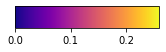

In [139]:
colorbar(join(itol_dir, 'mantel.uwdist.pearson.itol-r_colorbar.pdf'),
         cmax=node_df_pearson['r'].max(),
         size=(2.5,.6))

FileNotFoundError: [Errno 2] No such file or directory: '../samde/python/itolfish/mantel.uwdist.spearman.itol-r_colorbar.pdf'

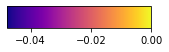

In [140]:
colorbar(join(itol_dir, 'mantel.uwdist.spearman.itol-r_colorbar.pdf'),
         cmax=node_df_spearman['r'].max(),
         size=(2.5,.6))

In [ ]:
colorbar(join(itol_dir, 'mantel_partial.uwdist.pearson.itol-r_colorbar.pdf'),
         cmax=node_df_pearson_partial['r'].max(),
         size=(2.5,.6))

In [ ]:
colorbar(join(itol_dir, 'mantel_partial.uwdist.spearman.itol-r_colorbar.pdf'),
         cmax=node_df_spearman_partial['r'].max(),
         size=(2.5,.6))

In [141]:
def get_colors(vals, col, cmap=mpl.cm.plasma):
    norm = mpl.colors.Normalize(vmin=0, vmax=np.max(vals))
    
    colors = []
    
    for i in vals:
        rgb = mpl.cm.ScalarMappable(norm=norm,
                                    cmap=cmap).to_rgba(i)
        hex_val = mpl.colors.rgb2hex(rgb)
        colors.append(hex_val)

    return(colors)

def write_itol_colors(node_df, col, fp, label='branch_colors'):
    out = ('DATASET_STYLE\n\n'
           'SEPARATOR SPACE\n\n'
           'COLOR #ffff00\n\n'
           'DATASET_LABEL %s\n\n'
           'DATA\n'
           '#NODE_ID TYPE COLOR LABEL_OR_STYLE SIZE_FACTOR\n' % label)

    for i, row in node_df.iterrows():
        out += '{0} branch node {1} 2 normal\n'.format(i, row[col])

    with open(fp, 'w') as f:
        f.write(out)

In [142]:
#LEGEND_TITLE,Dataset legend
#LEGEND_SHAPES,1,2,3
#LEGEND_COLORS,#ff0000,#00ff00,#0000ff
#LEGEND_LABELS,value1,value2,value3

In [143]:
node_df_pearson['r_color'] = get_colors(node_df_pearson['r'], col='r')
node_df_spearman['r_color'] = get_colors(node_df_spearman['r'], col='r')

ValueError: minvalue must be less than or equal to maxvalue

In [144]:
node_df_pearson_partial['r_color'] = get_colors(node_df_pearson_partial['r'], col='r')
node_df_spearman_partial['r_color'] = get_colors(node_df_spearman_partial['r'], col='r')

ValueError: minvalue must be less than or equal to maxvalue

In [ ]:
write_itol_colors(node_df_pearson, 
                  'r_color', 
                  join(itol_dir, 'mantel.uwdist.pearson.itol-r_colors.txt'),
                  label='pearson_r')
write_itol_colors(node_df_spearman, 
                  'r_color',
                  join(itol_dir, 'mantel.uwdist.spearman.itol-r_colors.txt'),
                  label='spearman_r')

In [ ]:
write_itol_colors(node_df_pearson_partial, 
                  'r_color', 
                  join(itol_dir, 'mantel_partial.uwdist.pearson.itol-r_colors.txt'),
                  label='pearson_r_partial')
write_itol_colors(node_df_spearman_partial, 
                  'r_color',
                  join(itol_dir, 'mantel_partial.uwdist.spearman.itol-r_colors.txt'),
                  label='spearman_r_partial')

Write pie chart p val indicator file

In [ ]:

# 9132,0,50,11000
def write_pval_pies(node_df, col, fp, label='p-vals', breaks = [0.001, 0.01, 0.05]):
    header = ("DATASET_PIECHART\n"
              "SEPARATOR SPACE\n"
              "DATASET_LABEL %s\n"
              "COLOR #ff0000\n"
              "FIELD_COLORS #ff0000\n"
              "FIELD_LABELS p-value\n"
              "MAXIMUM_SIZE 30\n"
              "BORDER_WIDTH 0\n"
              "DATA\n" % label)
    
    break_sizes = [int(30 - i/len(breaks)*30) for i, x in enumerate(breaks)]
    pies = []
    for i, row in node_df.iterrows():
        size = 0
        for s, b in enumerate(breaks):
            if row[col] > b:
                continue
            else:
                size = break_sizes[s]
                break
        if size > 0:
            pies.append("{0} 0 {1} 1".format(i, size))
    
    out = header + '\n'.join(pies)
    
    with open(fp, 'w') as f:
        f.write(out)

In [ ]:

write_pval_pies(node_df_pearson, 
                'p', 
                join(itol_dir, 'mantel.uwdist.pearson.itol-p_pies.txt'), 
                label='pearson_p')
write_pval_pies(node_df_spearman, 
                'p', 
                join(itol_dir, 'mantel.uwdist.spearman.itol-p_pies.txt'),
                label='spearman_p')

In [ ]:
write_pval_pies(node_df_pearson_partial, 
                'p',
                join(itol_dir, 'mantel_partial.uwdist.pearson.itol-p_pies.txt'),
                label='pearson_p_partial')
write_pval_pies(node_df_spearman_partial, 
                'p',
                join(itol_dir, 'mantel_partial.uwdist.spearman.itol-p_pies.txt'),
                label='spearman_p_partial')

In [ ]:
def write_clade_highlights(md_df, tree, tax_col, tree_col, fp,
                           label='clade_highlights',
                           colors=None, alpha=0.4, cmap=mpl.cm.Set3):
    out = ('DATASET_COLORSTRIP\n\n'
           'SEPARATOR SPACE\n\n'
           'COLOR #b2df8a\n\n'
           'DATASET_LABEL %s\n\n'% label)
    
    taxa = md_df[tax_col].unique()
    
    if colors is None:
        clist = cmap(range(len(taxa)), alpha=alpha)
        rgblist = ['rgba(%s,%s,%s,%s)' % (int(x[0]*255),
                                          int(x[1]*255),
                                          int(x[2]*255),
                                          x[3]) for x in clist]
        colors = {x: rgblist[i] for i, x in enumerate(taxa)}
    
    legend_shapes = ' '.join(['1']*len(taxa))
    legend_colors = ''
    legend_labels = ''
    
    for x in colors:
        legend_colors += ' %s' % colors[x]
        legend_labels += ' %s' % x
    
    out += ('LEGEND_TITLE host_colors\n'
            'LEGEND_SHAPES {0}\n'
            'LEGEND_COLORS{1}\n'
            'LEGEND_LABELS{2}\n\nDATA\n').format(legend_shapes,
                                            legend_colors,
                                            legend_labels)
        
    for taxon in taxa:
        tips = set(md_df.loc[md_df[tax_col] == taxon, tree_col])
        node = tree.lowest_common_ancestor(tips)
        
        out += "{0} {1}\n".format(node.name, colors[taxon])
#         out += "{0} range {1} {2}\n".format(node.name, colors[taxon], taxon)
        
    with open(fp, 'w') as f:
        f.write(out)

In [204]:
class_colors = {'Actinopterygii': '#b2df8a',
                 'Mammalia': '#1f78b4',}

write_clade_highlights(host_md, 
                       host_tree_subset, 
                       'host', 
                       'treetax',
                       join(itol_dir, 'mantel.itol-Class_colors.txt'),
                       colors=class_colors)

## Taxa bar chart for itol

In [147]:
md_dir = '../samde/python/metadata'
tax_md_fp = join(md_dir, 'taxabarchart.csv')
tax_itol = pd.read_csv(tax_md_fp, sep=',')
tax_itol

,taxtree,Proteobacteria,Planctomycetota,Verrucomicrobiota,Firmicutes,Actinobacteriota,Desulfobacterota,Bacteroidota,Cyanobacteria,Fusobacteriota
0,Antidorcas_marsupialis,1,0,0,145,1,0,40,0,0
1,Bos_javanicus,0,0,1,70,0,0,21,0,0
2,Budorcas_taxicolor,1,0,4,78,0,1,70,0,0
3,Gazella_spekei,1,0,6,131,2,0,32,0,0
4,Ovis_ammon,0,0,1,194,306,0,34,1,0
...,...,...,...,...,...,...,...,...,...,...
195,Ovis_aries,374,22,513,56875,167,233,23001,608,0
196,Porites_lobata,186009,237,175,51,36,48,2360,685,93
197,Pocillopora_elegans,183608,293,228,21,90,149,3019,9627,168
198,Acropora_hyacinthus,39601,817,1547,33,129,140,5694,3405,91


In [173]:
def get_qualitative_colors(fields, cmap=mpl.cm.Set3, alpha=0.4):
    clist = cmap(range(len(taxa)), alpha=alpha)
    rgblist = ['rgba(%s,%s,%s,%s)' % (int(x[0]*255),
                                      int(x[1]*255),
                                      int(x[2]*255),
                                      x[3]) for x in clist]
    return(rgblist)

def format_iTOL_multibar(fields, md, 
                         tree_ref_col=None, 
                         field_colors=None, 
                         field_labels=None, 
                         dataset_label='Multibar Chart', 
                         dataset_color=None, 
                         legend=True, 
                         unstacked=False,
                         width=1000, 
                         margin=0,
                         alpha=0.8,
                        ):
    """
    fields: array of columns titles in [metadata] to chart
    metadata: pd.df containing samples to graph and data
    """
    
    if field_labels is None:
        field_labels=fields
    
    if field_colors is None:
        field_colors=get_qualitative_colors(fields, alpha=alpha)
    
    if tree_ref_col is None:
        tree_ref_col=metadata.columns[0]

    if dataset_color is None:
        dataset_color = "#00FF00"

    # remove nans
    metadata = md.loc[:,fields + [tree_ref_col]].dropna()
    
    outstring = ''
    
    outstring += 'DATASET_MULTIBAR\n'
    outstring += 'SEPARATOR TAB\n'
    outstring += 'DATASET_LABEL\t%s\n' % dataset_label
    outstring += 'COLOR\t%s\n' % dataset_color
    outstring += 'FIELD_COLORS\t%s\n' % '\t'.join(field_colors)
    outstring += 'FIELD_LABELS\t%s\n' % '\t'.join(field_labels)    
    
    if legend:
        outstring += 'LEGEND_TITLE\tDataset legend\n'
        outstring += 'LEGEND_SHAPES\t%s\n' % '\t'.join(['1']*len(fields))
        outstring += 'LEGEND_COLORS\t%s\n' % '\t'.join(field_colors)
        outstring += 'LEGEND_LABELS\t%s\n' % '\t'.join(field_labels)
    
    outstring += 'MARGIN\t%s\n' % margin
    outstring += 'WIDTH\t%s\n' % width

    if unstacked:
        outstring += 'ALIGN_FIELDS\t1\n'
        
    outstring += 'DATA\n'
    for index, row in metadata.iterrows():
        outstring += row[tree_ref_col].replace(' ', '_') + '\t%s\n' % '\t'.join([str(row[x]) for x in fields])

    return(outstring)

In [60]:
fields = ['Proteobacteria',
 'Planctomycetota',
 'Verrucomicrobiota',
 'Firmicutes',
 'Actinobacteriota',
 'Desulfobacterota',
 'Bacteroidota',
 'Cyanobacteria',
 'Fusobacteriota']


In [80]:
bar = format_iTOL_multibar(fields, 
                     tax_itol, 
                     tree_ref_col='taxtree', 
                     field_colors=['#a6cee3',
                                   '#cab2d6',
                                   '#1f78b4',
                                   '#33a02c',
                                   '#6a3d9a',
                                   '#b2df8a',
                                   '#fb9a99',
                                   '#e31a1c',
                                   '#ff7f00',], 
                     field_labels=['Proteobacteria',
 'Planctomycetota',
 'Verrucomicrobiota',
 'Firmicutes',
 'Actinobacteriota',
 'Desulfobacterota',
 'Bacteroidota',
 'Cyanobacteria',
 'Fusobacteriota'], 
                     dataset_label='Taxa barchart2', 
                     dataset_color=None, 
                     legend=True,
                     width=200, 
                     alpha=1.0)

with open(join(itol_dir, 'mantel.itol-taxa_bar.txt'), 'w') as f:
    f.write(bar)

Now to make the diet highlights for tree

In [208]:
def write_diet_highlights(md_df, tree, tax_col, tree_col, fp,
                           label='diet_colors',
                           colors=None, alpha=0.4, cmap=mpl.cm.Set3):
    out = ('DATASET_COLORSTRIP\n\n'
           'SEPARATOR SPACE\n\n'
           'COLOR #b2df8a\n\n'
           'DATASET_LABEL %s\n\n'% label)
    
    taxa = md_df[tax_col].unique()
    
    if colors is None:
        clist = cmap(range(len(taxa)), alpha=alpha)
        rgblist = ['rgba(%s,%s,%s,%s)' % (int(x[0]*255),
                                          int(x[1]*255),
                                          int(x[2]*255),
                                          x[3]) for x in clist]
        colors = {x: rgblist[i] for i, x in enumerate(taxa)}
    
    legend_shapes = ' '.join(['1']*len(taxa))
    legend_colors = ''
    legend_labels = ''
    
    for x in colors:
        legend_colors += ' %s' % colors[x]
        legend_labels += ' %s' % x
    
    out += ('LEGEND_TITLE diet_colors\n'
            'LEGEND_SHAPES {0}\n'
            'LEGEND_COLORS{1}\n'
            'LEGEND_LABELS{2}\n\nDATA\n').format(legend_shapes,
                                            legend_colors,
                                            legend_labels)
        
    for taxon in taxa:
        tips = set(md_df.loc[md_df[tax_col] == taxon, tree_col])
        node = tree.lowest_common_ancestor(tips)
        
        out += "{0} {1}\n".format(node.name, colors[taxon])
#         out += "{0} range {1} {2}\n".format(node.name, colors[taxon], taxon)
        
    with open(fp, 'w') as f:
        f.write(out)

In [209]:
diet_colors = {'carnivore': '#b2df8a',
                 'herbivore': '#1f78b4',
                   'omnivore' : '#33a02c',
                      'planktivore' : '#6a3d9a',
                        'detritivore' : '#b2df8a',
                          'corallivore' : '#fb9a99'}

write_diet_highlights(host_md, 
                       host_tree_subset, 
                       'diet2', 
                       'treetax',
                       join(itol_dir, 'mantel.itol-diet_colors.txt'),
                       colors=diet_colors)

In [210]:
host_md

,treetax,sampleid,sampletaxid,order,family,genus,species,diet,run,diet1,host,diet2,diet3,type,taxaname
0,Abudefduf_sexfasciatus,25,Abudefduf_sexfasciatus,Ovalentaria,Pomacentridae,Abudefduf,sexfasciatus,planktivore,c,omnivore,Actinopterygii,planktivore,planktivore,animal,"""Abudefduf sexfasciatus"""
1,Aepyceros_melampus,410Impala,Aepyceros_melampus,Artiodactyla,Bovidae,Aepyceros,melampus,H,d,herbivore,Mammalia,herbivore,H,animal,"""Aepyceros melampus"""
2,Ailuropoda_melanoleuca,GP,Ailuropoda_melanoleuca,Carnivora,Ursidae,Ailuropoda,melanoleuca,H,a,herbivore,Mammalia,herbivore,H,animal,"""Ailuropoda melanoleuca"""
3,Ailurus_fulgens,RP,Ailurus_fulgens,Carnivora,Ursidae,Ailurus,fulgens,H,a,herbivore,Mammalia,herbivore,H,animal,"""Ailurus fulgens"""
4,Apodemus_flavicollis,21YellowneckedFieldMouse,Apodemus_flavicollis,Rodentia,Muridae,Apodemus,flavicollis,O,d,omnivore,Mammalia,omnivore,O,animal,"""Apodemus flavicollis"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,Trachypithecus_hatinhensis,238HanumanLangur,Trachypithecus_hatinhensis,Primates,Cercopithecidae,Trachypithecus,hatinhensis,H,d,herbivore,Mammalia,herbivore,H,animal,"""Trachypithecus hatinhensis"""
104,Trichosurus_vulpecula,287CommonBrushtail,Trichosurus_vulpecula,Diprotodontia,Phalangeridae,Trichosurus,vulpecula,O,d,omnivore,Mammalia,omnivore,O,animal,"""Trichosurus vulpecula"""
105,Ursus_arctos,231BrownBear,Ursus_arctos,Carnivora,Ursidae,Ursus,arctos,O,d,omnivore,Mammalia,omnivore,O,animal,"""Ursus arctos"""
106,Vulpes_vulpes,109RedFox,Vulpes_vulpes,Carnivora,Canidae,Vulpes,vulpes,O,d,omnivore,Mammalia,omnivore,O,animal,"""Vulpes vulpes"""


In [211]:
host_tree_subset

<TreeNode, name: node419, internal node count: 106, tips count: 108>

## Now trying to make figure with seaborn

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

In [19]:
cd 'OneDrive - UCLA IT Services/Fish Project/ISLAND COMPILED PROJECT/python'

/mnt/c/Users/samde/OneDrive - UCLA IT Services/Fish Project/ISLAND COMPILED PROJECT/python


In [50]:
df = pd.read_csv('faith_pd_merged.txt', delimiter = "\t")

In [25]:
df

,id,sampletaxid,order,family,genus,species,diet,run,diet1,host,diet2,diet3,type,taxaname,tax,faith_pd
0,GP,Ailuropoda_melanoleuca,Carnivora,Ursidae,Ailuropoda,melanoleuca,H,a,herbivore,Mammalia,herbivore,H,animal,"""Ailuropoda melanoleuca""",Ailuropoda_melanoleuca,4.394684
1,RP,Ailurus_fulgens,Carnivora,Ursidae,Ailurus,fulgens,H,a,herbivore,Mammalia,herbivore,H,animal,"""Ailurus fulgens""",Ailurus_fulgens,4.074280
2,29,Rhinecanthus_aculeatus,Tetraodontiformes,Balistidae,Rhinecanthus,aculeatus,omnivore,c,omnivore,Actinopterygii,omnivore,omnivore,animal,"""Rhinecanthus aculeatus""",Rhinecanthus_aculeatus,25.982524
3,48,Rhinecanthus_aculeatus,Tetraodontiformes,Balistidae,Rhinecanthus,aculeatus,omnivore,c,omnivore,Actinopterygii,omnivore,omnivore,animal,"""Rhinecanthus aculeatus""",Rhinecanthus_aculeatus,17.935094
4,74,Rhinecanthus_aculeatus,Tetraodontiformes,Balistidae,Rhinecanthus,aculeatus,omnivore,c,omnivore,Actinopterygii,omnivore,omnivore,animal,"""Rhinecanthus aculeatus""",Rhinecanthus_aculeatus,23.936364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,M158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.890753
782,M251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.949555
783,M66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.263455
784,M96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.289411


In [125]:
df2 = df[(df["host"] == "Mammalia") | (df["host"] == "Actinopterygii")]

In [71]:
df2 = df2[df2['host'].notnull()].copy()
df2['host'] = df2['host'].astype('category')
df2['host']

0            Mammalia
1            Mammalia
2      Actinopterygii
3      Actinopterygii
4      Actinopterygii
            ...      
773             algae
774             algae
775             algae
776             algae
777             algae
Name: host, Length: 732, dtype: category
Categories (5, object): ['Actinopterygii', 'Mammalia', 'algae', 'coral', 'water']

In [72]:
#df2['host'].cat.reorder_categories(['Mammalia','Actinopterygii','coral','water','algae'],inplace=True)

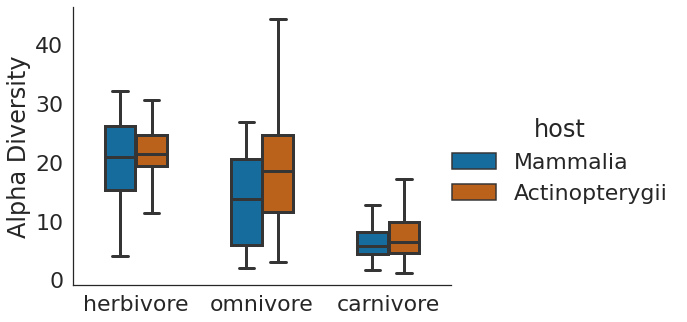

In [169]:
sns.set(font_scale = 2)
sns.set_style(style='white')
s1=sns.catplot(x="diet1", y="faith_pd", hue="host", kind="box", data=df2,showfliers=False,aspect=4/3,linewidth=3,width=0.5,palette=["#0072B2", "#D55E00"])
s1.set(xlabel=None)

s1.set(ylabel="Alpha Diversity")

plt.show()

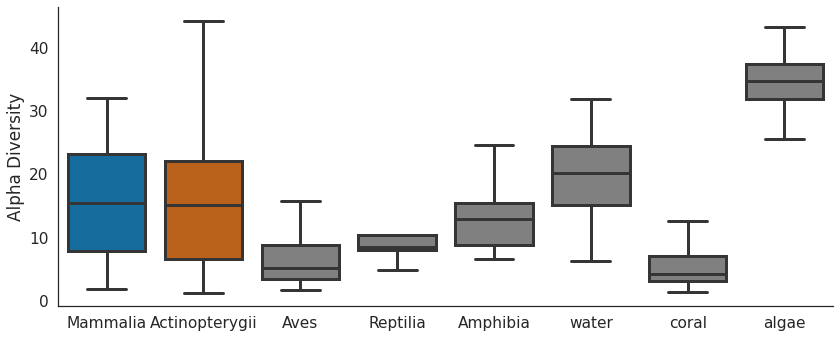

In [168]:
sns.set(font_scale = 1.4)
sns.set_style(style='white')
s2=sns.catplot(x="host", y="faith_pd", kind="box", data=df,showfliers=False,aspect=7/3,linewidth=3,palette=["#0072B2", "#D55E00",
                "gray","gray","gray","gray","gray","gray"])
s2.set(xlabel=None)
s2.set(ylabel="Alpha Diversity")


plt.show()

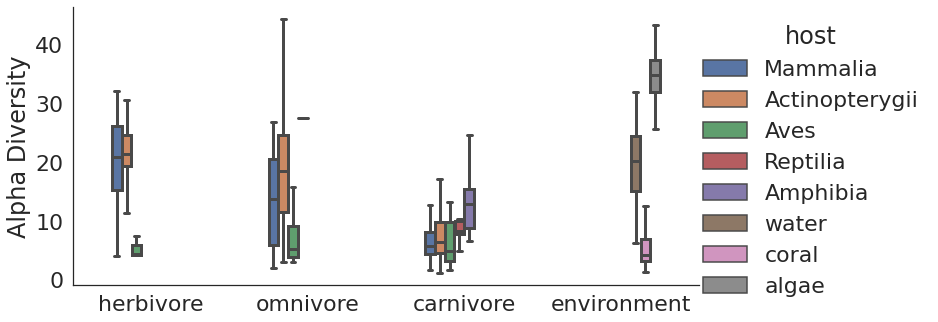

In [182]:
sns.set(font_scale = 2)
sns.set_style(style='white')
s3=sns.catplot(x="diet1", y="faith_pd", hue="host", kind="box", data=df,showfliers=False,aspect=4/2,linewidth=3,width=0.5)
s3.set(xlabel=None)

s3.set(ylabel="Alpha Diversity")

plt.show()

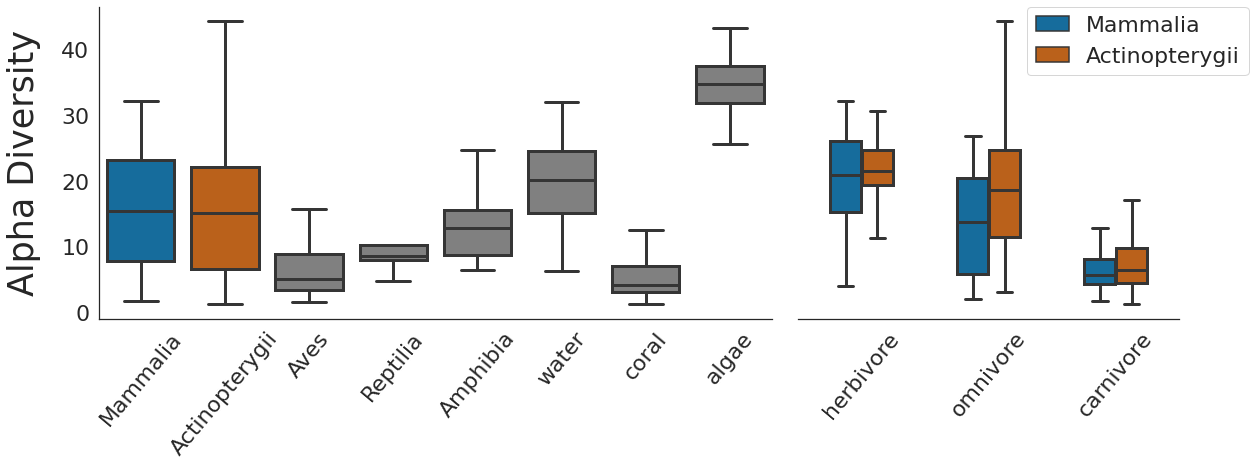

In [299]:
f, axs = plt.subplots(1,2,
                      figsize=(17,7),
                      sharey=True,gridspec_kw=dict(width_ratios=[3,1.7]))



plt.xticks(rotation=45)
g1=sns.boxplot(x="host", y="faith_pd", data=df,showfliers=False,linewidth=3,palette=["#0072B2", "#D55E00",
                "gray","gray","gray","gray","gray","gray"],ax=axs[0])
g1.set(xlabel=None)
g1.set_xticklabels(g1.get_xticklabels(), rotation=50)
g1.spines['right'].set_visible(False)
g1.spines['top'].set_visible(False)
g1.set_ylabel('Alpha Diversity',size=35,labelpad=20)


g2=sns.boxplot(x="diet1", y="faith_pd", hue="host", data=df2,showfliers=False,linewidth=3,width=0.5,palette=["#0072B2", "#D55E00"],ax=axs[1])
g2.set(xlabel=None)
g2.set(ylabel=None)
g2.set_xticklabels(g2.get_xticklabels(), rotation=50)
g2.spines['right'].set_visible(False)
g2.spines['top'].set_visible(False)
g2.spines['left'].set_visible(False)


sns.set_style(style='white')
plt.tight_layout()
plt.legend(bbox_to_anchor=(0.6, 1), loc='upper left', borderaxespad=0, handlelength=1.5)
sns.set(font_scale = 2)
sns.set_style(style='white')


plt.savefig('AlphaDiversityHostDiet.pdf', dpi=300, bbox_inches='tight')
plt.show()